# Running Sentiment Analysis on Illinois Tweets

Used Vader Sentiment Analysis to conduct sentiment analysis on all tweets. 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Link to this Sentiment Analyzer: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [28]:
tqdm.pandas() # Allows us to see progress bars on pandas.apply methods

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [29]:
style.use('fivethirtyeight')

In [30]:
# Reading in state data

il_df = pd.read_csv('./data/IL_full.csv', low_memory=False)
ga_df = pd.read_csv('./data/GA_full.csv', low_memory=False)

In [31]:
il_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'springfield', 'pritzker', 'virus']
ga_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'atlanta', 'kemp', 'virus']

In [32]:
il_df_covid = il_df.copy()[il_df['text'].str.contains('|'.join(il_covid_terms))]
ga_df_covid = ga_df.copy()[ga_df['text'].str.contains('|'.join(ga_covid_terms))]

In [33]:
# provided from link 
def sentiment_analyzer_scores(sentence):    
    score = analyser.polarity_scores(sentence)
    return score

In [34]:
# Analyze our city data
def vader_analyzer(data):
    '''
    Takes pandas dataframe of info scraped from twitter and performs sentiment
    analysis. Creates 5 new columns to be used in sentiment analysis:
    'neg_score' - negative score
    'neu_score' - neutral score
    'pos_score' - positive score
    'compound_score' - (score < -0.05 = negative
                        score between -0.05 and 0.05 = neutral
                        score > 0.05 = positive)
    '''
    data['sentiment_analysis'] = data.progress_apply(lambda x: sentiment_analyzer_scores(x['text']), axis=1)
    data['neg_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neg'])
    data['neu_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neu'])
    data['pos_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['pos'])
    data['compound_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['compound'])

In [35]:
# Converting date to a datetime object in local time
def create_time_cols(data, timezone):
    # Creating datetime
    data['datetime'] = pd.to_datetime(data['date'], utc=True)
    
    timezone_map = {'eastern': -4,
                    'central': -5,
                    'mountain': -6,
                    'pacific': -7}
    
    # Changing datetime to local time
    data['datetime_local_time'] = data['datetime'].apply(lambda x: x - timedelta(hours=timezone_map[timezone]))
        
    # Creating relevant columns for plotting xticks
    data['month_day_hour'] = data['datetime_local_time'].dt.strftime(date_format='%m%d%H')
    data['month_day'] = data['datetime_local_time'].dt.strftime(date_format='%m-%d')

In [36]:
# ga_df['datetime'] = pd.to_datetime(ga_df['date'], utc=True, errors='coerce') 
# ga_df['datetime_local'] = ga_df['datetime'].apply(lambda x: x - timedelta(hours=-6))
# ga_df['month_day_hour'] = ga_df['datetime_local'].dt.strftime(date_format='%m%d%H')
# ga_df['month_day'] = ga_df['datetime_local'].dt.strftime(date_format='%m-%d')
# hour_group = ga_df.groupby('month_day_hour').mean()
# ga_df['datetime_local']


# hour_group = ga_df.groupby('month_day_hour').mean()[['compound_score']]
# days = ga_df['month_day'].sort_values().unique()
    

In [37]:
def plot_state_sentiment(data, timezone, covid_only=False):
    # Creating this variable for x tick marks
    hour_group = data.groupby('month_day_hour').mean()[['compound_score']]
    days = data['month_day'].sort_values().unique()
    
    timezone_map = {'eastern': -4,
                'central': -5,
                'mountain': -6,
                'pacific': -7}
    
    # Offset to ensure that the 'date shutdown announced' line lands on the right gridline
    axis_offset_map = {'eastern': '04', 
                           'central': '05',
                           'mountain': '06',
                           'pacific': '07'}
    
    # Create sentiment plot
    plt.figure(figsize=(32, 6))
    
#     sns.lineplot(data=hour_group, x=hour_group.index, y='compound_score', linewidth=2.5)
   
    sns.lineplot(data=data, x='month_day_hour', y='compound_score', linewidth=2.5, color='blue')
    
    plt.axhspan(-.05, .05, color='gray', alpha=0.3)
    plt.axhspan(.05, np.percentile(data['compound_score'], 90), color='green', alpha=0.3)
    plt.axhspan(-.05, np.percentile(data['compound_score'], 10), color='red', alpha=0.3)
    

    
    plt.xticks(range(timezone_map[timezone], len(hour_group), 24), days)
    
    # Sorry this isn't human readable :( it returns the date in the proper format to be plotted
    plt.axvline(str(timeline_dict[data['state'].reset_index().loc[0, 'state']] [0])[4:] + '00') 
    
    plt.legend(['_', 'Date shutdown was announced'])
    
    if covid_only:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms')
    else:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Compound Score')
    plt.show();

In [38]:
def analyze_and_plot_sentiment(data, timezone, covid_only=False):
    vader_analyzer(data)
    create_time_cols(data, timezone)
    plot_state_sentiment(data, timezone, covid_only)

In [39]:
timeline_dict = {
    'FL': [20200401, 20200605],
    'TX': [20200331, 20200518],
    'NJ': [20200316, 20200609],
    'NY': [20200322, 20200613],
    'IL': [20200320, 20200529],
    'GA': [20200402, 20200601],
    'OH': [20200322, 20200526],
    'MI': [20200323, 20200608]
}

In [43]:
covid_term_data = [[il_df_covid, 'central'], 
                   [ga_df_covid, 'eastern']]

In [45]:
# Initializing Vader model 
analyser = SentimentIntensityAnalyzer()

100%|██████████| 26123/26123 [00:00<00:00, 1187134.91it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020B9B540F88> has a label of '_' which cannot be automatically added to the legend.


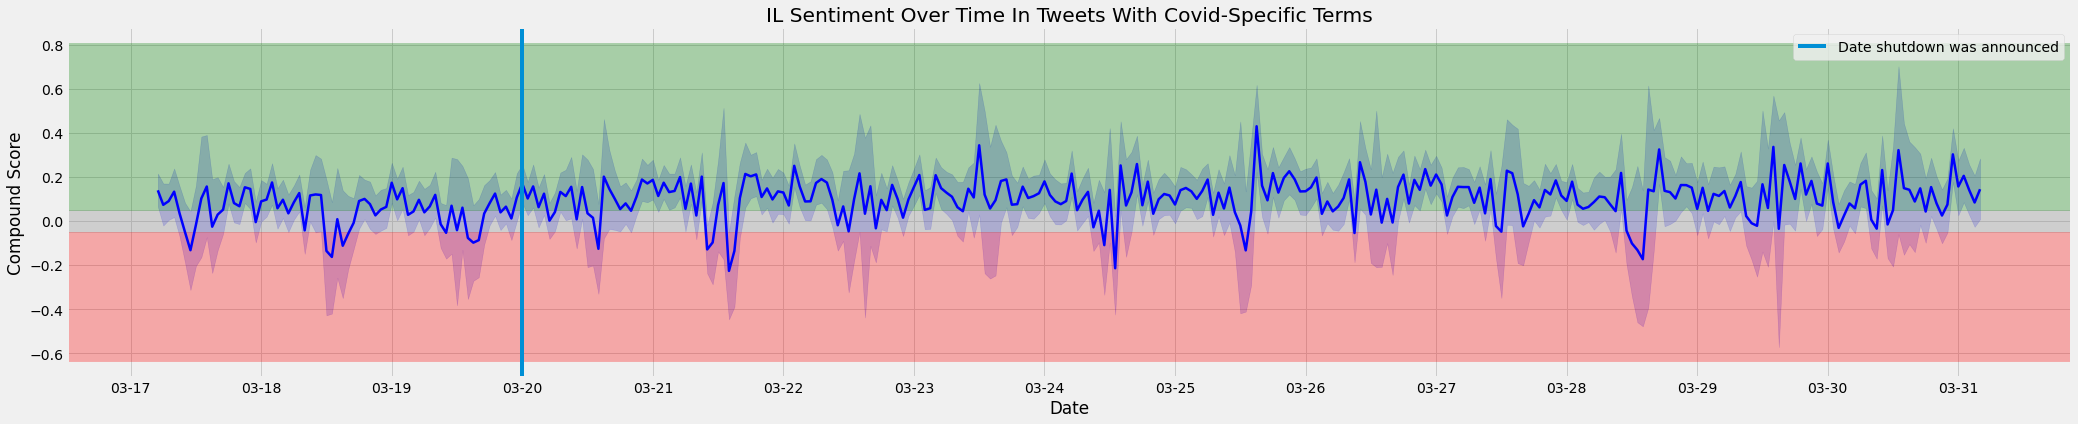

100%|██████████| 12430/12430 [00:00<00:00, 1035579.19it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020B90C8E7C8> has a label of '_' which cannot be automatically added to the legend.


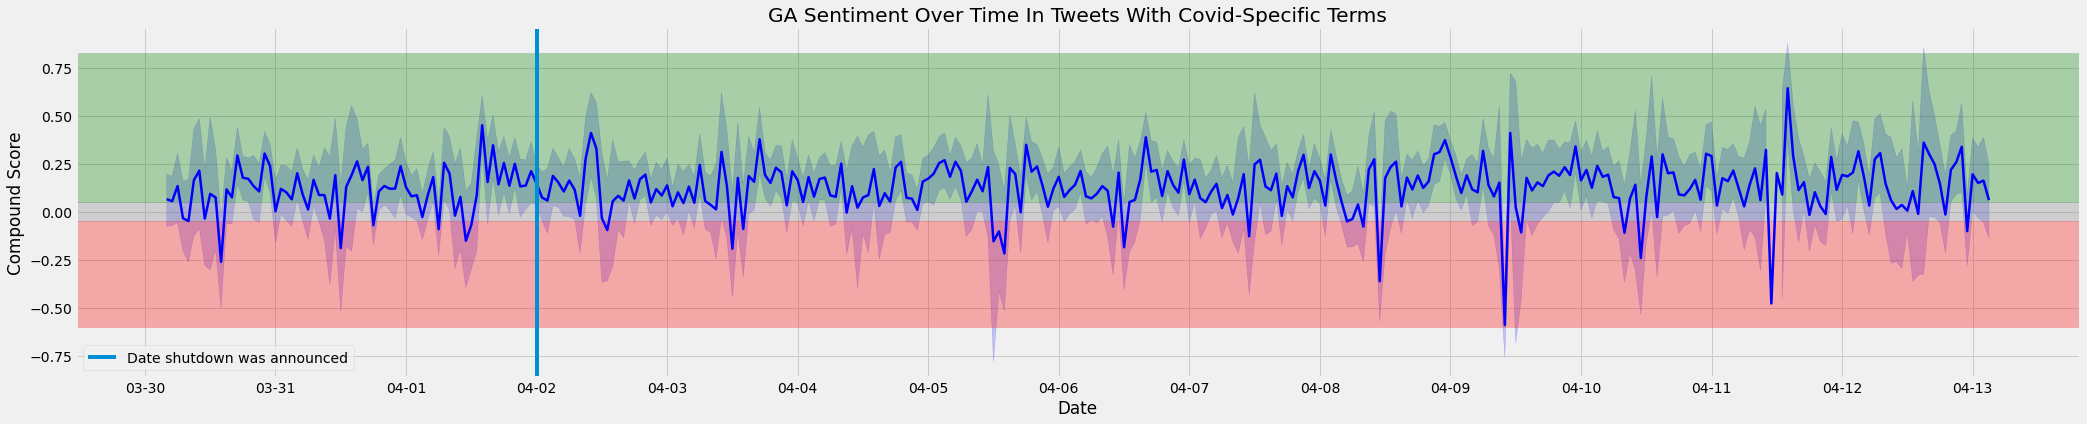

In [46]:
for i in range(len(covid_term_data)):
    analyze_and_plot_sentiment(covid_term_data[i][0], covid_term_data[i][1], covid_only=True)

In [49]:
general_terms_data = [[il_df, 'central'], 
                   [ga_df, 'eastern']]

100%|██████████| 163230/163230 [00:00<00:00, 1208844.33it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020B96A3A648> has a label of '_' which cannot be automatically added to the legend.


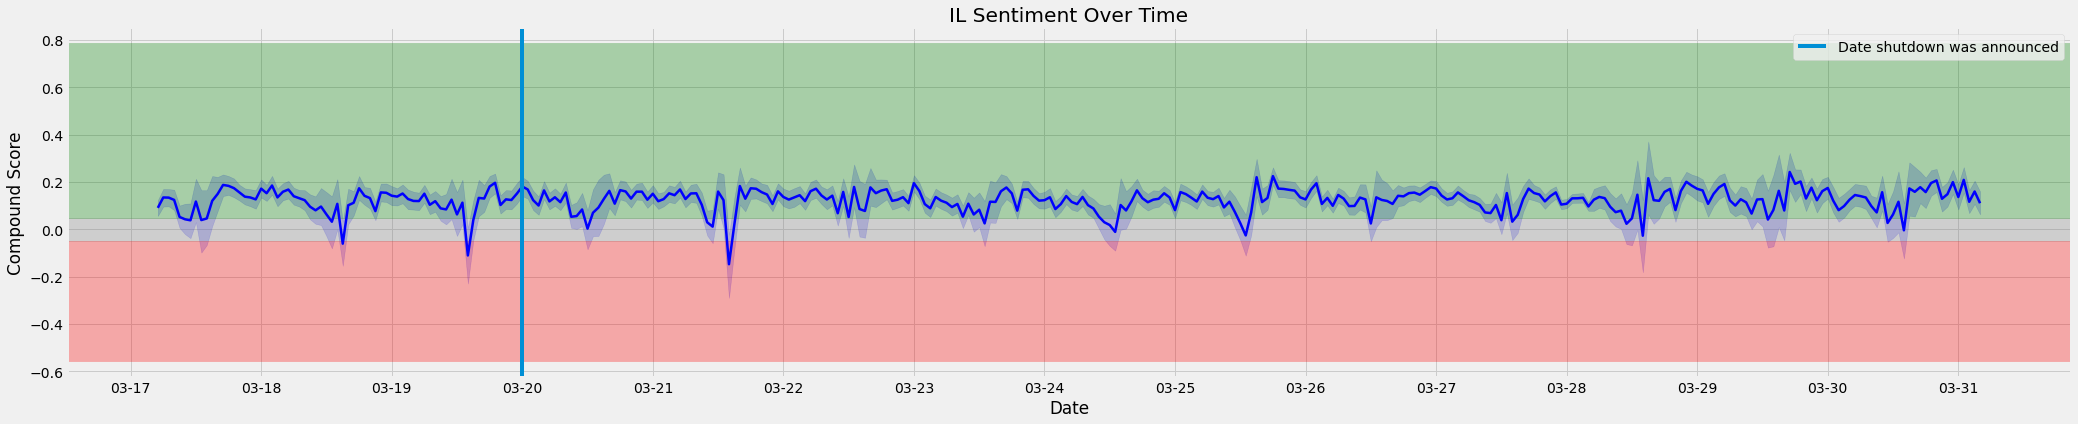

100%|██████████| 122788/122788 [00:00<00:00, 1215449.35it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020B931E3848> has a label of '_' which cannot be automatically added to the legend.


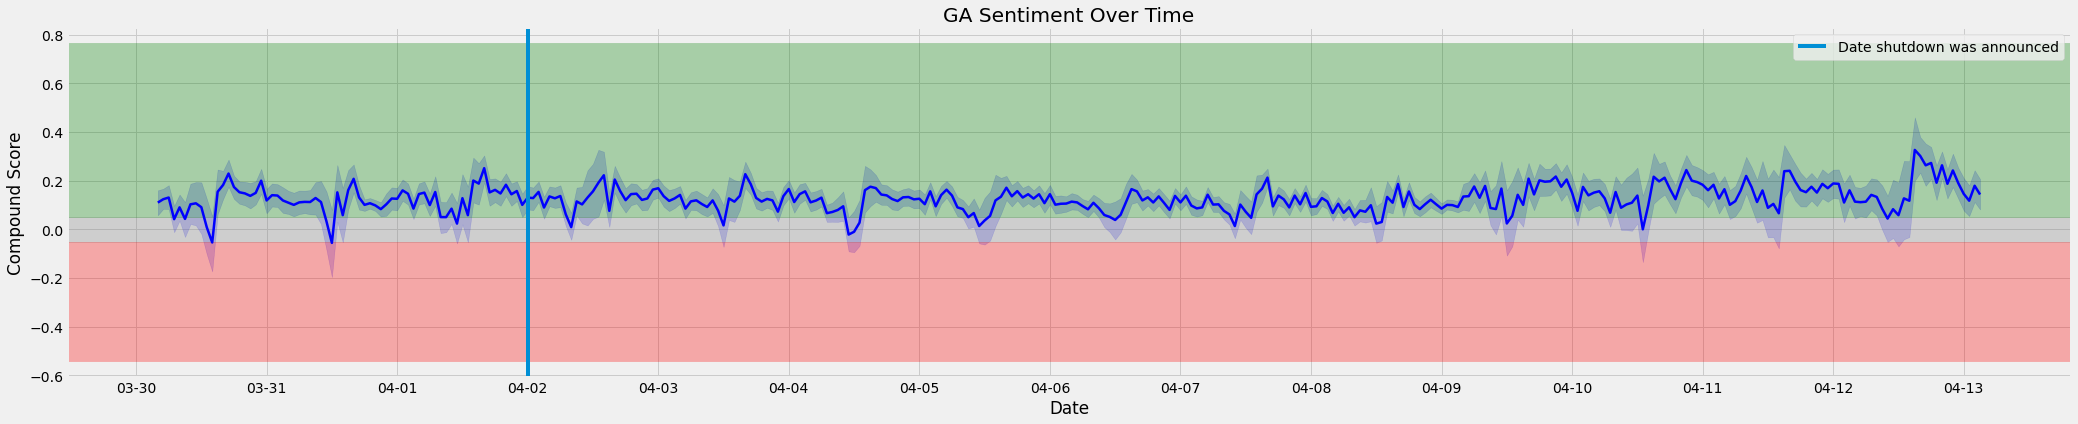

In [51]:
for i in range(len(general_terms_data)):
    analyze_and_plot_sentiment(general_terms_data[i][0], general_terms_data[i][1], covid_only=False)